<a href="https://colab.research.google.com/github/geoc1234/sourdough/blob/development/notebooks/HeatMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The kinetics of fermentation depends on temperature of the dough.  During the bulk fermentation process, the temperature is essentially held constant.  However, during the “cold retard” phase, if the recipe calls for such, the temperature is decreasing over time.  Depending on the rate of heat transfer to the refrigerator compared to the rate of heat redistribution in the dough, the dough temperature can vary by large amounts throughout the dough.  This situation is described mathematically by the heat equation (Eq 1) below:

$$
 C_{p} \rho\frac{\partial T}{\partial t} = k\nabla^2 T \tag{1}
$$

subject to a set of boundary conditions and an initial condition.  The Laplacian operator $\nabla^2$ depends on the coordinate system. It can be though of as measuring how much the temperature gradient varies in small regions sampled throughout dough.

The constant $\alpha = \frac{C_{p}\rho}{k}$ is a measure of thermal mass of the dough (i.e. resistance to temperature changes) divided by the mobility of thermal energy to move into or out of a region.

Our primary interest is modeling the cold retard, since that is the situation with the greatest non-uniformity in temperature, other than the baking step.

For simplicity, we assume the dough is shaped like a puck.  For a boule shaped banneton, the dough has cylindrical symmetry.  The assumption of cylindrial symmetry is less accurate for the top and botom of the puck.  the top surface of the banneton is certainly flat (as assumed).  However, the bottom surface is more spherical.However, we shall assume the top and bottom of the puck are both flat.


Cylindrical coordinates is a reasonable choice to start with.  In cylindrical coordinates Eq(1) becomes Eq(2).
$$
\alpha \frac{\partial T(r,\theta,z,t)}{\partial t} = \frac{1}{r}\frac{\partial}{\partial r}(r\frac{\partial T}{\partial r})+\frac{1}{r^2}\frac{\partial^2T}{\partial \theta^2} + \frac{\partial^2T}{\partial z^2} \tag{2}
$$

The r dimension is the radial dimension, theta is the angle about the centerline axis (the azimuthal angle), and z represents the distance along the centerline axis.  Given the azimuthal symmetry of the loaf, the solution should not depend on θ, thus the above reduces to:
$$
\alpha \frac{\partial T(r,z,t)}{\partial t} = \frac{1}{r}\frac{\partial}{\partial r}(r\frac{\partial T}{\partial r})+ \frac{\partial^2T}{\partial z^2} \tag{3}
$$
Eq(3) is a partial differential equation in three dimensions.  Given that each term involves differentiation along a single dimension, it makes sense to first try separation of variables, i.e. to assume T = R(r)Z(z)U(t).  The solution is assumed to be the product of three functions, with each function being of a single dimension.  Substituting RUZ for T into Eq(3) yields:
$$
\alpha RZ\frac{\partial U(t)}{\partial t} = ZU\frac{1}{r}\frac{\partial}{\partial r}(r\frac{\partial R(r)}{\partial r})+ RU\frac{\partial^2Z(z)}{\partial z^2}\tag{4}
$$

Dividing each term in Eq(4) by RUZ yields Eq(5):
$$
\frac{\alpha}{U(t)}\frac{\partial U(t)}{\partial t} = \frac{1}{rR}\frac{\partial}{\partial r}(r\frac{\partial R(r)}{\partial r})+ \frac{1}{Z}\frac{\partial^2Z(z)}{\partial z^2}\tag{5}
$$

The terms are now completely separated.  Since the RHS must equal the LHS, and since each function is of a single dimension, the RHS and LHS must be equal to a constant.  Anticipating the need to introduce an additional separation constant to further split the terms on the RHS, we split the first separation constant into two terms λ and m.  The differential equation for U(t) becomes:

$$
\frac{\alpha}{U(t)}\frac{\partial U(t)}{\partial t} = -\lambda^2 - m^2 = - (\lambda^2 + m^2)\tag{6}
$$

Intuitively, we know the separation constants on the RHS of Eq(6) must be greater than or equal to zero because we have good reason to expect the time dependence of the dough temperature will be a simple decay everywhere in the dough.  Thus we require  > 0, and since  are independent, each of them must also be greater than zero.  We ensure that is the case by taking their square.  The RHS of Eq(5) becomes:

$$
\frac{1}{rR}\frac{\partial}{\partial r}(r\frac{\partial R(r)}{\partial r})+ \frac{1}{Z}\frac{\partial^2Z(z)}{\partial z^2} = -\lambda^2 - m^2\tag{7}
$$

Without any loss in generality, we can further separate Eq(7) into Eq(8) and Eq(9), where we have “allocated” each term to a single dimension.

$$
\frac{1}{rR}\frac{\partial}{\partial r}(r\frac{\partial R(r)}{\partial r}) = -\lambda^2\tag{8}
$$
$$
\frac{1}{Z}\frac{\partial^2Z(z)}{\partial z^2} =
- m^2\tag{9}
$$


The next step is to expand Eq(8) into a less compact form, i.e. into Eq(10)
$$
\frac{\partial^2 R(r)}{\partial r^2} + \frac{1}{r}\frac{\partial R(r)}{\partial r} + \lambda^2 R = 0 \tag{10}
$$
This looks a lot like Bessel’s equation, shown in Eq(11), only with v = 0, i.e.
$$
\frac{\partial^2 R(r)}{\partial r^2} + \frac{1}{r}\frac{\partial R(r)}{\partial r} + (\lambda^2 - v^2/r^2)R = 0 \tag{11}
$$
Thus the solution can be found in books or online as a linear combination of two well known Bessel functions:
$$
R(r) = c_1J_0(\lambda r) + c_2Y_0(\lambda r)\tag{12}
$$
According to the literature, Y(0) is unbounded, i.e. - , thus C2 must equal zero.  


We have two Boundary Conditions that need to be accounted for.  The first is that of convective heat loss from the radial surface, which fixes the derivative wrt r at the boundary, i.e. at r = a
$$
 \left. (\frac{\partial T}{\partial r} + \frac{h}{k}T) \right|_{r=a} = 0\tag{13}
$$
In Eq(13), h is the convective heat transfer coefficient from the radial surface of the dough, and k is the thermal conductivity of the dough.  Substituting Eq(12), with c2 = 0, into Eq(13) recasts Eq(13) into:
$$
 \left. (\frac{\partial J_0(\lambda_lr)}{\partial r} + \frac{h}{k}J_0(\lambda_lr)) \right|_{r=a} = 0\tag{14}
$$

The derivative of the zero order Bessel function in Eq(14) can be replaced by the negative of the first order Bessel function, yielding:
$$
 \left. -\lambda_lJ_1(\lambda_lr)
 + \frac{h}{k}J_0(\lambda_lr)) \right|_{r=a} = 0\tag{15}
$$

Thus, the allowable values of λ are those that satisfy Eq(15).  They need to be found numerically.  To do so, we set x = λa, to arrive at Eq(16), which we solve numerically to arrive at the allowable eigenvalues or roots.
$$
 -x J_1(x) + \frac{ha}{k}J_0(x) = 0\tag{16}
$$


weight 0.9500176184455534


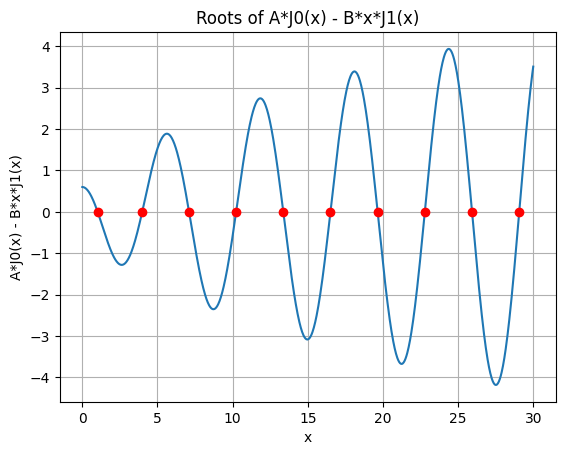

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1, j0, jn_zeros


# Define parameters
T_air = 37.0  # The refrigerator air temperature °F
T_0 = 74.0    # The initial bread temperature °F
radius = 6.0 # 2.0       # radius of the cylindrically shaped bread cm
height = 7.0 # 5.0       # height or length of the bread cm
convection_h = 0.00020   # Example value for 'h'
conduction_k = 0.002 # 0.00363  # Example value for 'k'
cp = 2092.0
rho = 0.0012
alpha = (cp*rho/conduction_k/3600) #0.1convert from sec to hrs
weight_boule = (np.pi*radius**2)*height*rho
print("weight",weight_boule)

num_roots_l = 50 # Number of terms for summation over l
num_roots_m = 50  # Number of terms for summation over m

r_resolution = 50 # Number of r-axis points
z_resolution = 50 # Number of z-axis points
t_resolution = 200 # Number of t-axis points

# Create arrays for plotting
r = np.linspace(0, radius,r_resolution )
z = np.linspace(0, height/2,z_resolution)
t = np.linspace(0, 48, t_resolution)  # Time in hrs

# Create a meshgrid for r and z
r_mesh, z_mesh = np.meshgrid(r, z)

# Initialize an empty array to store the temperature
# The shape now includes time
# create a (r_resolution, z_resolution, t_resolution) array for the Temperature field
T = np.zeros_like(r_mesh[..., None] * t[None, None, :])

def find_roots_lambda(A, B, x_range=(0,radius,1000), n_roots=num_roots_l):
    """
    Finds the roots of the equation A*J0(x) - B*x*J1(x) = 0 within a specified range.

    Args:
        A: Constant coefficient for J0(x).
        B: Constant coefficient for x*J1(x).
        x_range: Tuple specifying the range for searching roots.
        n_roots: The number of roots to find.

    Returns:
        A NumPy array containing the approximate roots of the equation.

    """
    roots = []
    x = np.linspace(x_range[0], x_range[1], x_range[2])
    y = A * j0(x) - B * x * j1(x)

    # Find zero crossings
    for i in range(len(x)-1):
      if (y[i] > 0 and y[i+1] < 0) or (y[i] < 0 and y[i+1] > 0):
        root = x[i] - y[i] * (x[i+1] - x[i])/(y[i+1] - y[i])
        roots.append(root)
        if len(roots) == n_roots:
          break;

    return np.array(roots)

def find_roots_m(A, B, H = height, x_range=(0,height,1000), n_roots=num_roots_m):
    """
    Finds the roots of the equation A*x*sin(x) - B*cos(x) = 0 within a specified range.

    Args:
        A: Constant coefficient for x*sin(x).
        B: Constant coefficient for cos(x).
        x_range: Tuple specifying the range for searching roots.
        n_roots: The number of roots to find.

    Returns:
        A NumPy array containing the approximate roots of the equation.

    """
    roots = []
    x = np.linspace(x_range[0], x_range[1],x_range[2])
    y = A * x * np.sin(x * (H/2)) - B * np.cos(x * (H/2))

    # Find zero crossings
    for i in range(len(x)-1):
      if (y[i] > 0 and y[i+1] < 0) or (y[i] < 0 and y[i+1] > 0):
        root = x[i] - y[i] * (x[i+1] - x[i])/(y[i+1] - y[i])
        roots.append(root)
      if len(roots) == n_roots:
        break;
    return np.array(roots)

def calc_coefficient_l(xl, a=9):
  # expects input xl = lambda_l*a
  term1 = 2.0/(radius**2 * (j0(xl)**2 + j1(xl)**2))
  term2 = a**2*j1(xl)/xl
  #print("coeff", term1*term2)
  return term1*term2

def calc_coefficient_z(xz,H=7):
  # expects input xz = root_m
  term1 = (H/2) + np.sin(xz*H)/(2*xz)
  term2 = (2/xz)*np.sin(xz*H/2)
  return term2/term1

A = (convection_h/conduction_k)*radius
B = 1
l_rootsRange = 5*radius
l_range=(0,l_rootsRange,10000)
roots_l = find_roots_lambda(A, B,l_range, num_roots_l)
x = np.linspace(0,l_rootsRange,1000)
y = A * j0(x) - B * x * j1(x)
plt.plot(x, y)
plt.plot(roots_l, np.zeros_like(roots_l), "ro")
plt.xlabel("x")
plt.ylabel("A*J0(x) - B*x*J1(x)")
plt.title("Roots of A*J0(x) - B*x*J1(x)")
plt.grid(True)
plt.show()


 <font size = "3"> The values of C in Eq(12) can be found from the initial condition, which is assumed to be that of a uniform temperature across the surface of the dough.  According to a text book on series of Bessel functions, the coefficients of the Bessel series can be determined from:
$$
c_l = \frac{2}{a^2[J_0^2(\lambda_l a) + J_1^2(\lambda_l a)]}\int_0^a rf(r)J_0(\lambda_l a)dr\tag{17}
$$
A uniform temperature distribution at t = 0 is modeled by setting f(r) = 1 in Eq (17)
$$
c_l = \frac{2}{a^2[J_0^2(\lambda_l a) + J_1^2(\lambda_l a)]}\int_0^a rJ_0(\lambda_l r)dr = \frac{2}{a^2[J_0^2(\lambda_l a) + J_1^2(\lambda_l a)]}\int_0^{\lambda_l a} \frac{z}{\lambda_l^2}J_0(z)dz \rightarrow \\
c_l=\frac{2}{a^2[J_0^2(x_l) + J_1^2(x_l)]}\frac{a^2J_1(x_l)}{x_l}\tag{18}
$$
where xl are the roots found previously via Eq(16).


Next, we need to find the solutions to Eq(9), which are well known sine and cosine series:
$Z_m(z) = A_msin(mz) - B_mcos(mz)$

From the symmetry condition (z=0 assumed to be in the center, i.e. half-way between each end, of the cylinder, about which the solution is symmetric and thus the gradient of the temperature must be zero at that point) and the boundary condition at Z(H/2), which is also assumed to be via convective heat loss:
$$
\left.\frac{dZ(z)}{dz} \right |_{0} = A_mmcos(mz) - B_mmsin(mz) = 0; \ A_m = 0\tag{19a}
$$
$$
\left.\frac{dZ(z)}{dz} \right |_{H/2} = - B_mmsin(m\frac{H}{2}) = -\frac{h}{k}B_mcos(m\frac{H}{2})\tag{19b}
$$
In Eq(19), we have assumed the cylinder has overall length of H, and since the solution is symmetric, we only need solve for one end of the cylinder.  As with the radial function, we find the allowable values of m by finding the zeros of Eq(19) (or the slightly simplified Eq20):
$$
m{sin(m\frac{H}{2})} -\frac{h}{k}cos(m\frac{H}{2}) = 0\tag{20}
$$

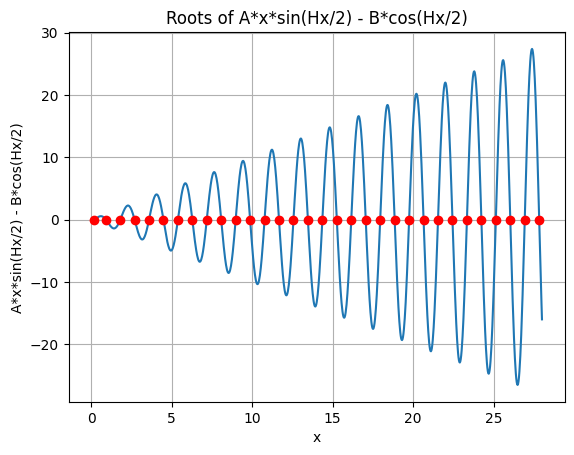

In [39]:
A = 1
B = (convection_h/conduction_k)
rootsRange = 4*height
zroots=[0, rootsRange, 1000]
roots_m = find_roots_m(A, B, height, zroots, n_roots= num_roots_m)
x = np.linspace(zroots[0],zroots[1],zroots[2])
y = A  * x * np.sin(x*height/2) - B * np.cos(x * height/2)
plt.plot(x, y)
plt.plot(roots_m, np.zeros_like(roots_m), "ro")
plt.xlabel("x")
plt.ylabel("A*x*sin(Hx/2) - B*cos(Hx/2)")
plt.title("Roots of A*x*sin(Hx/2) - B*cos(Hx/2)")
plt.grid(True)
plt.show()

Similar to the radial coordinate, we find the coefficients Bm from the initial condition on Z.  For the Temperature at t=0 to be uniform everywhere requires:
$$
\sum_{m} B_m cos(mz) = 1\tag{21}
$$
This is solved simply by multiplying both sides by  and integrating over the domain 0 to H/2:
$$
RHS: \ \int_0^{H/2} cos(n z)dz = \frac{1}{n}sin(\frac{nH}{2})
$$
<font size = "2">
$$LHS:\ \int_{0}^{H/2}B_mcos(mz)cos(nz)dz = \frac{1}{2} \int_{0}^{H/2} B_m (cos([m+n]z)+ cos([m-n]z))dz = \frac{B_m}{2}[\frac{sin[(m+n)H/2]}{m+n} + \frac{sin[(m-n)H/2]}{m-n}]
$$
<font size = "3">
$$
B_m = \frac{\frac{2}{n}sin(\frac{nH}{2})}{(\frac{sin([m+n](H/2)}{m+n}+ \frac{sin([m-n](H/2)}{m-n})}\tag{22}
$$

When n = m = 0, Eq(22) $B_m = \frac{H}{H} = 1$ ; but the smallest value of m found by solving for roots of Eq(19) was > 0.  So m = n = 0 cannot occur.

When n = m  0, Eq(22) $B_m = \frac{\frac{2}{m}sin(\frac{mH}{2})}{\frac{sin(mH)}{2m}+\frac{H}{2}}$  

And, when $n \not=m$, Eq(22)$B_m = 0$ by orthogonality of the eigenvectors with eigen values $n \not=m$ .

We can check this solution for the values of Bm by confirming that the series in Eq(22), i.e.    does, in fact, converge to 1 for all values of z between 0 and H/2.

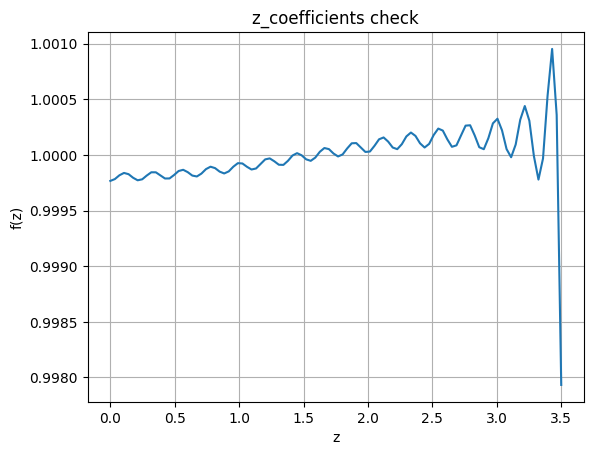

In [40]:
# check coefficient calcs by confirming initial condition is ~ 1.0 across entire domain
z_check = np.linspace(0,height/2,100)
fz = np.zeros_like(z_check)
for n in range(0, len(roots_m)):
  m_root = roots_m[n-1]
  fz += calc_coefficient_z(m_root,height) * np.cos((m_root * z_check))
plt.plot(z_check,fz)
plt.xlabel("z")
plt.ylabel("f(z)")
plt.title("z_coefficients check")
plt.grid(True)
plt.show()


Putting all of this together:
<br><br>
$$
T(r,z,t) =  T_{air} + (T_0 - T_{air})\sum_{l}\sum_{n}[c_lJ_0(\lambda_l r)][B_ncos(nz)]e^{-(\lambda_l^2+ n^2)\frac{t}{\alpha}}
\tag{23}$$
with:
$$
c_l=\frac{2}{a^2[J_0^2(x_l) + J_1^2(x_l)]}\frac{a^2J_1(x_l)}{x_l} \ and\ \lambda_l = x_l/a
$$
<br>
$$
B_m = \frac{\frac{2}{m}sin(\frac{mH}{2})}{\frac{sin(mH)}{2m}+\frac{H}{2}}
$$
<br>
$$
\alpha = \frac{C_{p}\rho}{k}
$$




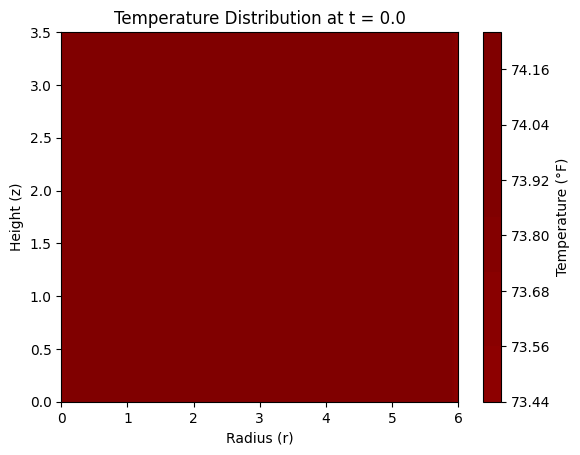

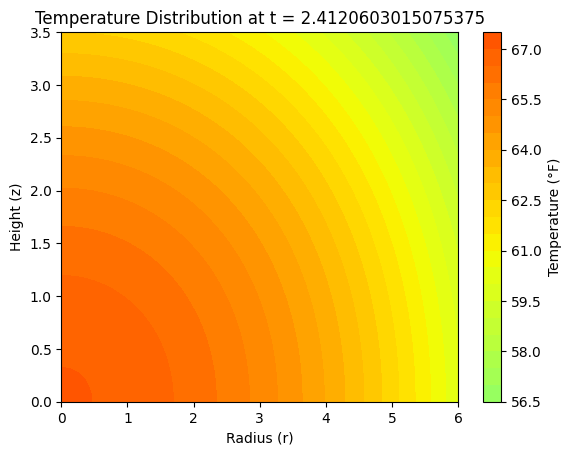

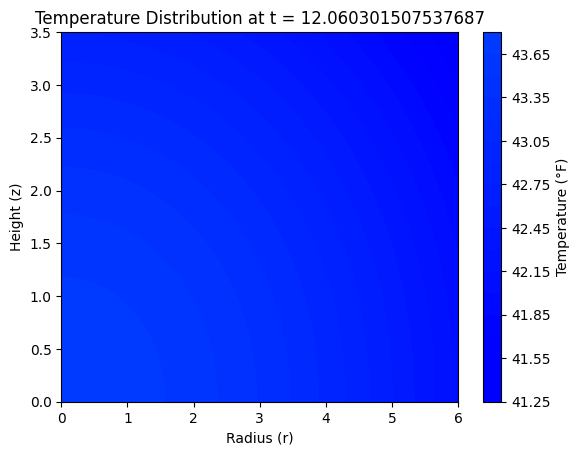

In [41]:

# Calculate the temperature at each point in the mesh
for l in range(0, len(roots_l)):
    # Use square brackets to access elements of the roots_j0 array
    xl = roots_l[l-1]
    lambda_l = xl/radius
    for n in range(0, len(roots_m)):
        m_root = roots_m[n-1]
        exp_term = np.exp(-(((lambda_l)**2 + (m_root**2)) * t[None, None, :]) / alpha)
        T +=  (T_0 - T_air)* (j0(lambda_l * r_mesh[..., None]) * calc_coefficient_l(xl, radius)) * \
        calc_coefficient_z(m_root,height) * np.cos((m_root * z_mesh[..., None])) * exp_term

# Add the air temperature to the result
T += T_air

# Plot the temperature distribution at a specific time (e.g.,t=49)
time_index = 0 # Time index
dr = radius/r_resolution

plt.contourf(r_mesh, z_mesh, T[:,:,time_index], levels=20, cmap='jet', vmin=T_air, vmax=T_0)
plt.colorbar(label='Temperature (°F)')
plt.xlabel('Radius (r)')
plt.ylabel('Height (z)')
plt.title('Temperature Distribution at t = {}'.format(t[time_index]))
plt.show()
plt.show()

time_index = 10 # Time index (0-199)
plt.contourf(r_mesh, z_mesh, T[:,:,time_index], levels=20, cmap='jet', vmin=T_air, vmax=T_0)
plt.colorbar(label='Temperature (°F)')
plt.xlabel('Radius (r)')
plt.ylabel('Height (z)')
plt.title('Temperature Distribution at t = {}'.format(t[time_index]))
plt.show()
plt.show()

time_index = 50 # Time index (0-199)
plt.contourf(r_mesh, z_mesh, T[:,:,time_index], levels=20, cmap='jet', vmin=T_air, vmax=T_0)
plt.colorbar(label='Temperature (°F)')
plt.xlabel('Radius (r)')
plt.ylabel('Height (z)')
plt.title('Temperature Distribution at t = {}'.format(t[time_index]))
plt.show()
plt.show()



shape T:  (50, 50, 200)


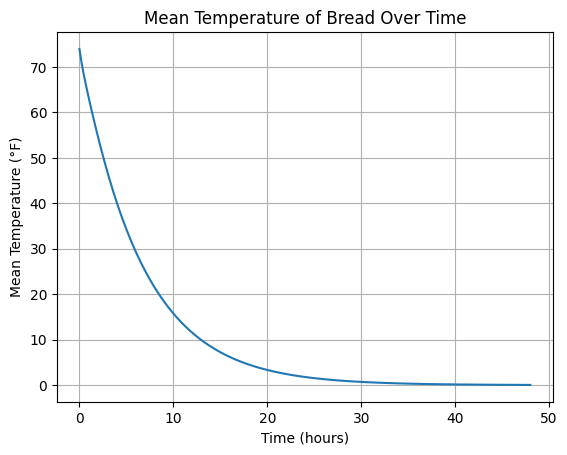

In [21]:
# Extract the mean temperature at each time step
# Activation energy (J/mol/K)
E_a = 55000.0
# Gas constant (J/mol/K)
R = 8.314
mean_temperatures = np.mean(T, axis=(0, 1))
weighted_mean_temperatures = []
weighted_mean_temperatures_Kelvin = []

print(f'shape T: ', np.shape(T))

for i in range (0,len(t)):
  weighted_mean_temperatures.append(np.sum(np.mean(T[:,:,i],axis=1)*(2.0*r*dr)/np.pow(radius,2),axis=0))

weighted_mean_temperatures_Kelvin = (np.array(weighted_mean_temperatures) + 40.0)/1.8 + 233.15

# Create the plot
plt.plot(t, weighted_mean_temperatures)
plt.xlabel('Time (hours)')
plt.ylabel('Mean Temperature (°F)')
plt.title('Mean Temperature of Bread Over Time')
plt.grid(True)
plt.show()


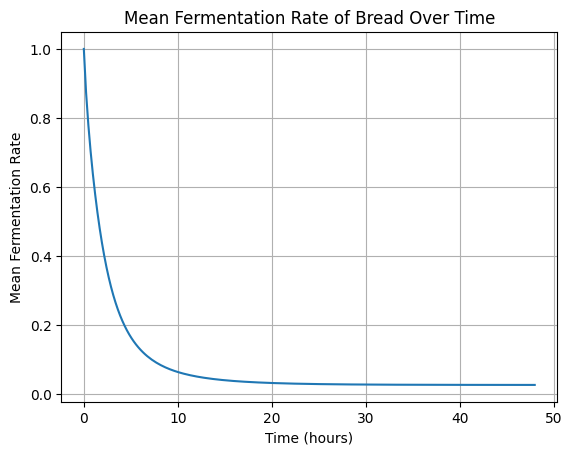

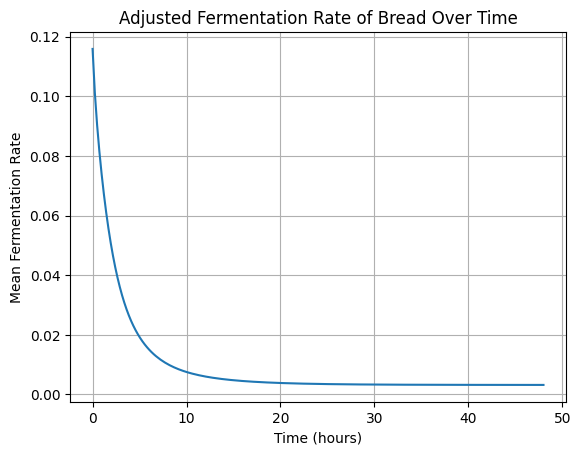

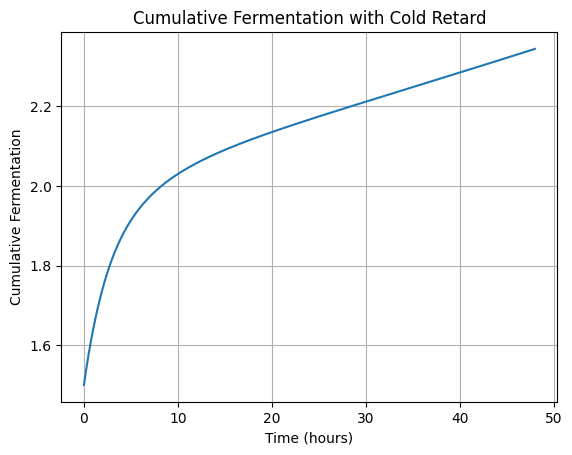

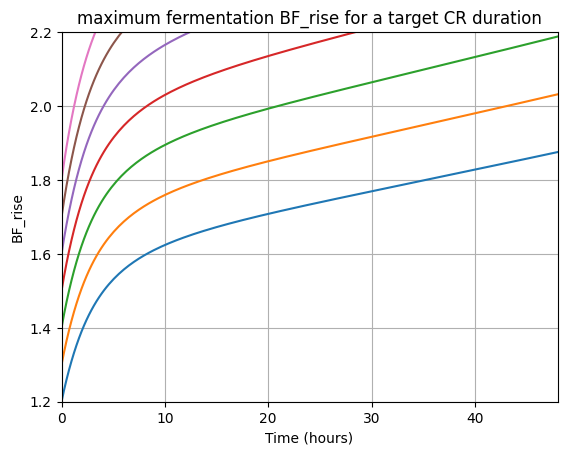

In [22]:
# Activation energy (J/mol/K)
E_a = 55000.0
# Gas constant (J/mol/K)
R = 8.314

mean_reaction_rate = (np.exp(-E_a / (R * weighted_mean_temperatures_Kelvin)))
k0 = mean_reaction_rate[0]
mean_reaction_rate /= k0

# Create the plot
plt.plot(t, mean_reaction_rate)
plt.xlabel('Time (hours)')
plt.ylabel('Mean Fermentation Rate')
plt.title('Mean Fermentation Rate of Bread Over Time')
plt.grid(True)
plt.show()

# Integrate the rate equation numerically to get the cumulative amount of fermentation occuring during cold retard.
"""
use doubling of the dough as a termination point, and expressing a starting point as the amount of rise achieved prior to start
of cold retard.
"""
# Use the rate of rise from the bulk fermentation phase to estimate the activity of the starter
BF_rise_time = 3.5 # hours (assumes the induction time has been subtracted)
BF_rise_amount = 1.5 # amount of rise achieved prior to cold retard
actual_rate = (np.log(BF_rise_amount)/BF_rise_time) # Because this is based on data from the Bulk fermentation phase, the temperature = T0.
mean_reaction_rate *= actual_rate
# Create the plot
plt.plot(t, mean_reaction_rate)
plt.xlabel('Time (hours)')
plt.ylabel('Mean Fermentation Rate')
plt.title('Adjusted Fermentation Rate of Bread Over Time')
plt.grid(True)
plt.show()

# Numerical integration (trapezoidal rule) accounting for the effect of cooling on the rate constant, k.
dt = t[1] - t[0]  # Time step
cumulative_fermentation = np.zeros_like(t)
cumulative_fermentation[0] = BF_rise_amount

for i in range(1, len(t)):
  cumulative_fermentation[i] = cumulative_fermentation[i - 1] + 0.5 * dt * (mean_reaction_rate[i-1] + mean_reaction_rate[i]) * cumulative_fermentation[i - 1]

# Plot the cumulative amount of fermentation
plt.plot(t, cumulative_fermentation)
plt.xlabel('Time (hours)')
plt.ylabel('Cumulative Fermentation')
plt.title('Cumulative Fermentation with Cold Retard')
plt.grid(True)
plt.show()

'''
invert the fermentation curve to find the target starting point
'''
factor_0 = 2/cumulative_fermentation[len(t)-1]
cumulative_fermentation *= factor_0
factor_1 = cumulative_fermentation[0]
yset_0 = np.zeros_like(t)
yset_1 = np.zeros_like(t)
yset_2 = np.zeros_like(t)
yset_3 = np.zeros_like(t)
yset_4 = np.zeros_like(t)
yset_5 = np.zeros_like(t)
yset_6 = np.zeros_like(t)
yset_0 = cumulative_fermentation * 1.2/factor_1
yset_1 = cumulative_fermentation * 1.3/factor_1
yset_2 = cumulative_fermentation * 1.4/factor_1
yset_3 = cumulative_fermentation * 1.5/factor_1
yset_4 = cumulative_fermentation * 1.6/factor_1
yset_5 = cumulative_fermentation * 1.7/factor_1
yset_6 = cumulative_fermentation * 1.8/factor_1
#plt.plot(t,cumulative_fermentation)
plt.plot(t,yset_0)
plt.plot(t,yset_1)
plt.plot(t,yset_2)
plt.plot(t,yset_3)
plt.plot(t,yset_4)
plt.plot(t,yset_5)
plt.plot(t,yset_6)
plt.ylim(1.2,2.2)
plt.xlim(0,48)
plt.xlabel('Time (hours)')
plt.ylabel('BF_rise')
plt.title('maximum fermentation BF_rise for a target CR duration')
plt.grid(True)
plt.show()